# Calculate emissions changes in well-mixed gas levels
Calculate the emissions changes in well-mixed gases at hemisphereic and globally averaged levels. 

In [1]:
import netCDF4 as nc
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import numpy as np

import os
import sys

sys.path.append(os.getcwd())
from utils import copy_netcdf_file, insert_interpolated_point, cutoff_netcdf_time

## Instructions for running the code 
One line here (the version string) is guaranteed to need updating each month that the code is run. File locations (particularly mod_input_folder, which references the data found in https://github.com/Priestley-Centre/COVID19_emissions) will need setting for each environment the code is run in. The input_folder variable references the folder with the original data from Input4MIPs (https://esgf-node.llnl.gov/search/input4mips/) in. 

In [2]:
version_string = "_v4.nc"  # CHANGE ON UPDATE

# File locations for input gas levels (from input4mips) and output data
input_folder = "../input/"
output_folder = "../output/GHGs/"
input_co2_mole = "mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_no2_mole = "mole-fraction-of-nitrous-oxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"
input_ch4_mole = "mole-fraction-of-methane-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc"

# We need to know the names of relevant variables in each of the different files
gases = {"co2": input_co2_mole, "n2o": input_no2_mole, "ch4": input_ch4_mole}
key_variables = {
    "co2": "mole_fraction_of_{}_in_air".format("carbon_dioxide"),
    "n2o": "mole_fraction_of_{}_in_air".format("nitrous_oxide"), 
    "ch4": "mole_fraction_of_{}_in_air".format("methane")
}
path_var_names = {"co2": "CO2(ppm)", "n2o": "N2O(ppb)", "ch4": "CH4(ppb)"}

# Modification factors - from a local version of the COVID10_emissions github
mod_input_folder = "../../COVID19_emissions_data/global_pathways/"
mod_input_baseline = "Base_pathway.xlsx"
mod_input_ff = "FossilFuel_pathway.xlsx"
mod_input_2yr= "TwoYearBlip_pathway.xlsx"
mod_input_4yr= "FourYearBlip_pathway.xlsx"
mod_input_mg = "ModerateGreen_pathway.xlsx"
mod_input_sg = "StrongGreen_pathway.xlsx"

pathway_files = [mod_input_baseline, mod_input_4yr]

year_range = np.arange(2020, 2050.01)
t0 = 2019
tcutoff = (2050.99 - 1850) * 365

Only change lines below here if you know what you're doing. 
## Calculations begin

In [3]:
baseline = pd.read_excel(mod_input_folder + mod_input_baseline, header=0, index_col=1, sheet_name="Concentrations")
baseline

,Unnamed: 0,CO2(ppm),CH4(ppb),N2O(ppb),CF4(ppt),C2F6(ppt),C6F14(ppt),HFC23(ppt),HFC32(ppt),HFC43_10(ppt),...,MCF(ppt),HCFC22(ppt),HCFC141B(ppt),HCFC142B(ppt),HALON1211(ppt),HALON1202(ppt),HALON1301(ppt),HALON2402(ppt),CH3BR(ppt),CH3CL(ppt)
year,,,,,,,,,,,,,,,,,,,,,
1765.041667,0,278.051529,722.000000,273.000000,34.497000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,13.097500,547.996000
1765.125000,1,278.054028,722.305451,273.000596,34.496996,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.580582,533.047268
1765.208333,2,278.056565,722.608130,273.001271,34.496993,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.114799,519.293771
1765.291667,3,278.059133,722.908063,273.002024,34.496989,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11.695094,506.639942
1765.375000,4,278.061730,723.205274,273.002856,34.496986,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,11.316909,494.997858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050.625000,3427,513.827036,1680.684661,332.274018,103.979962,6.467354,0.468703,27.882544,0.334575,0.218468,...,0.002966,174.758049,17.415766,8.266786,0.771551,5.603635e-09,2.181903,0.044494,7.804962,408.880765
2050.708333,3428,514.078656,1680.389648,332.317316,104.030333,6.471956,0.469114,27.872806,0.331860,0.218008,...,0.002917,173.834760,17.362108,8.235610,0.768321,5.444903e-09,2.179705,0.044311,7.804962,408.880765
2050.791667,3429,514.330293,1680.097266,332.360584,104.080704,6.476557,0.469525,27.863072,0.329189,0.217551,...,0.002869,172.914400,17.308487,8.204523,0.765103,5.290667e-09,2.177506,0.044129,7.804962,408.880765


In [4]:
def calc_means(df, year_range):
    to_return = pd.DataFrame(index=year_range, columns=["mean"])
    for year in year_range:
        to_return["mean"][year] = np.nanmean(df[df["year"].floordiv(1) == year][df.columns[1]])
    return to_return

In [5]:
def make_year_into_days(year):
    return (year - 1850) * 365 # The calendar is defined using the 365 day calendar. 

In [6]:
def closest_ind(info, time):
    return [np.where(
        abs(info - time) == min(abs(info - time))
    )[0][-1]]

In [7]:
monthly_range = [date for date in baseline.index if date >= min(year_range) and date < max(year_range) + 1]

Plot of scenario Base for co2
End time factor is 1.0
Plot of scenario FourYearBlip for co2
End time factor is 0.9968077994195806
Plot of scenario Base for n2o
End time factor is 1.0
Plot of scenario FourYearBlip for n2o
End time factor is 0.9995922356961027
Plot of scenario Base for ch4
End time factor is 1.0
Plot of scenario FourYearBlip for ch4
End time factor is 0.9997166712854424


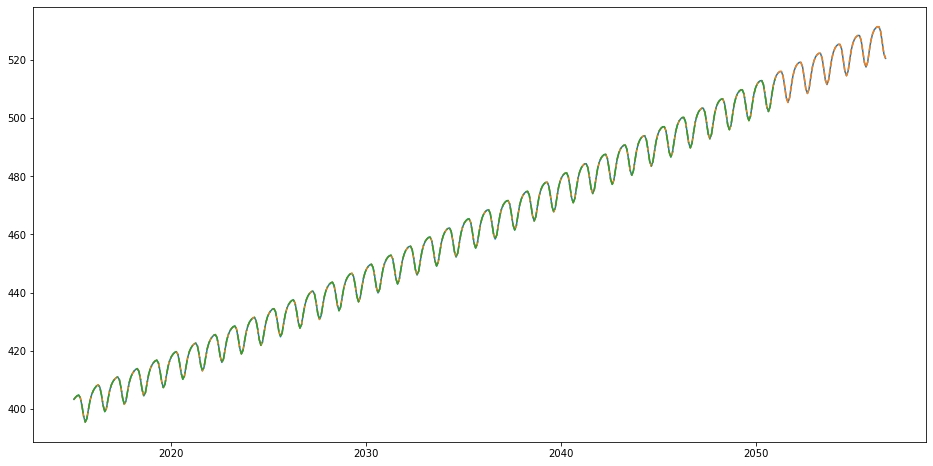

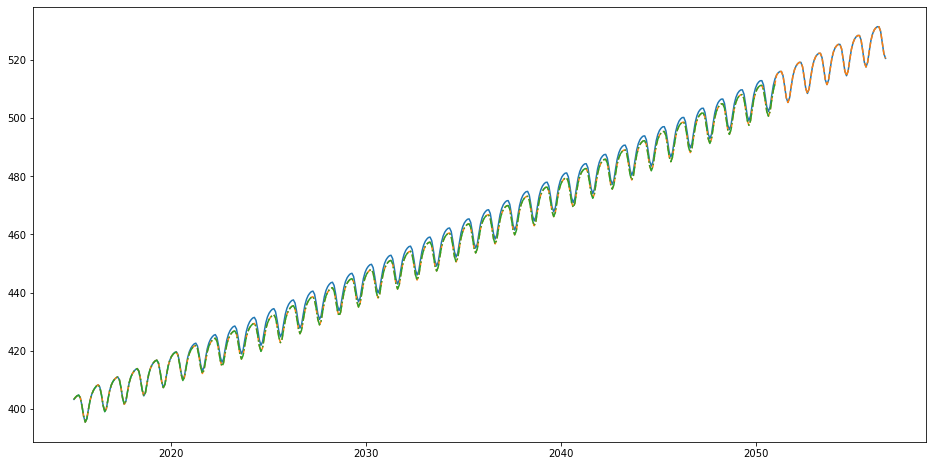

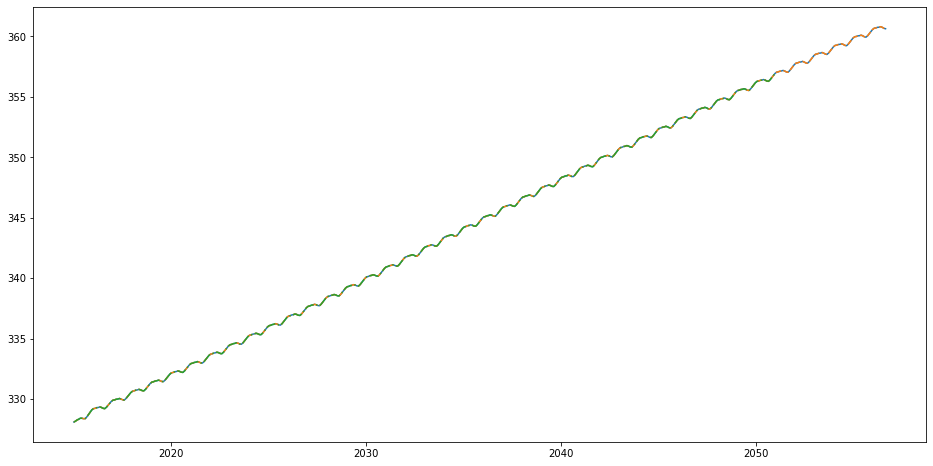

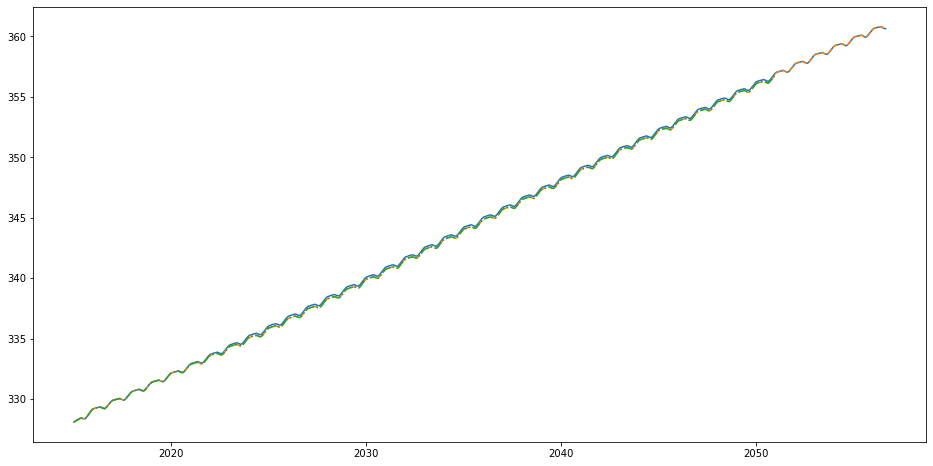

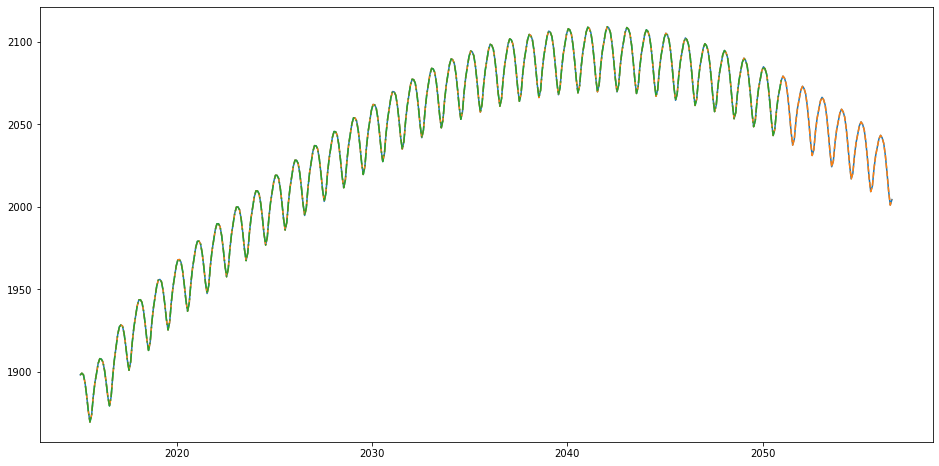

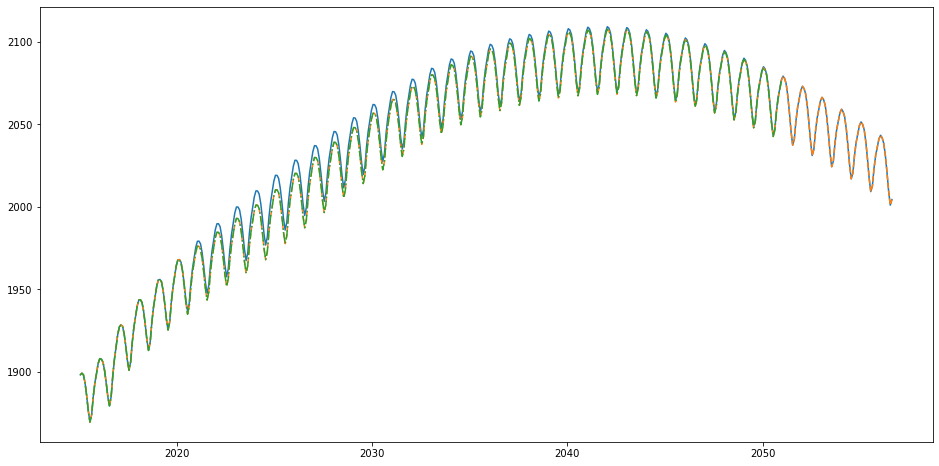

In [8]:
for gas, gas_file in gases.items():
    key_variable = key_variables[gas]
    for fileind in range(len(pathway_files)):
        file = pathway_files[fileind]
        scenario_string = file.split("_")[0]
        data = copy_netcdf_file(gas_file, input_folder, output_folder, scenario_string)
        output = data.variables[key_variable][...]
        path_df = pd.read_excel(mod_input_folder + file, header=0, index_col=1, sheet_name="Concentrations")
        for time in monthly_range:
            timeind = closest_ind(data.variables["time"][:], make_year_into_days(time))
            time_factor = path_df[path_var_names[gas]].loc[time] / baseline[path_var_names[gas]].loc[time]
            output[timeind, ...] = (output[timeind, :]) * time_factor 
        print("Plot of scenario {} for {}".format(scenario_string, gas))
        print("End time factor is {}".format(time_factor))
        plt.figure(figsize=(16, 8))
        plt.plot(data.variables["time"][:500] / 365 + 1850, data.variables[key_variable][:500, 1])
        plt.plot(data.variables["time"][:500] / 365 + 1850, output[:500, 1], linestyle="--")
        data.variables[key_variable][:, :] = output
        data.close()
        data = cutoff_netcdf_time(
            output_folder, output_folder, gas_file + scenario_string, tcutoff, scenario_string=version_string
        )
        plt.plot(data.variables["time"][:500] / 365 + 1850, data.variables[key_variable][:500, 1], linestyle="-.")
        data.close()

# Sandbox
This code does not need to be run and is purely for exploratory purposes.

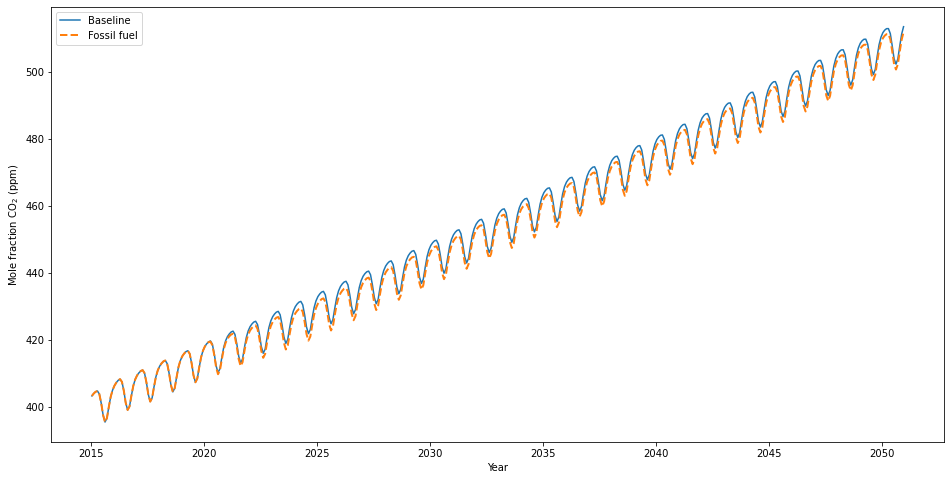

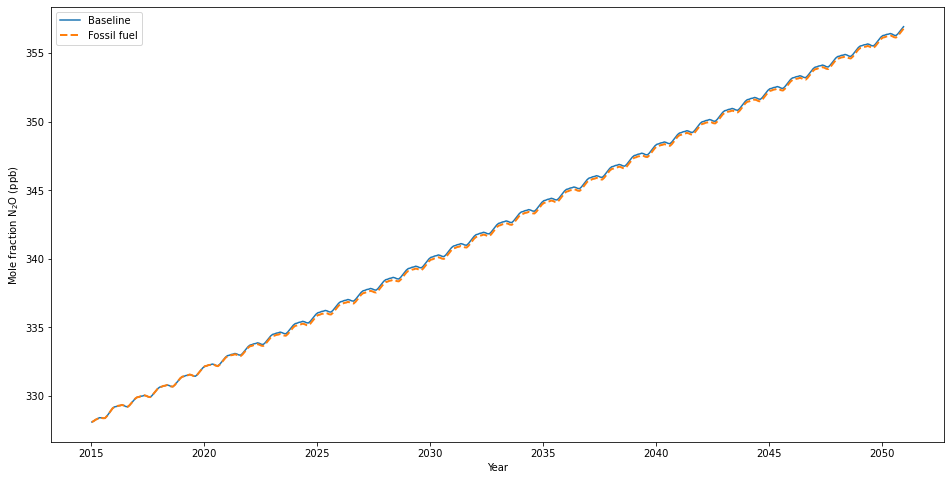

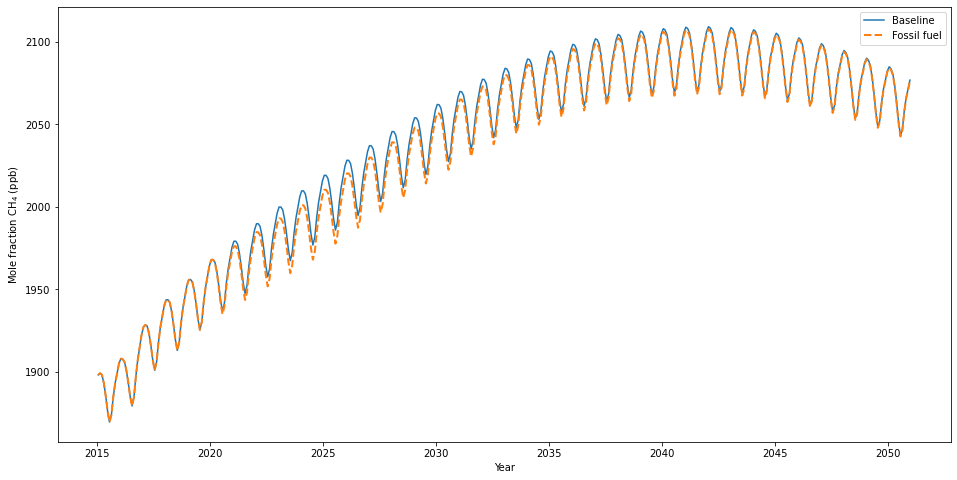

In [9]:
ystring = {"n2o": "N$_2$O (ppb)", "ch4": "CH$_4$ (ppb)", "co2": "CO$_2$ (ppm)"}
for gas, gas_file in gases.items():
    key_variable = key_variables[gas]
    plt.figure(figsize=(16, 8))
    for fileind in range(len(pathway_files)):
        file = pathway_files[fileind]
        scenario_string = file.split("_")[0]
        data = nc.Dataset(output_folder + "cut_" + gas_file + scenario_string + version_string)
        if fileind == 0:
            plt.plot(data.variables["time"][:] / 365 + 1850, data.variables[key_variable][:, 1])
        else:
            plt.plot(data.variables["time"][:] / 365 + 1850, data.variables[key_variable][:, 1], linestyle="--", linewidth=2)
    plt.legend(["Baseline", "Fossil fuel", "Two year blip", "Moderate green", "Strong green"])
    plt.xlabel("Year")
    plt.ylabel("Mole fraction {}".format(ystring[gas]))